In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------
# Load all datasets
# --------------------------------------------------------------
df_contrat = pd.read_csv("df_contrat.csv")
df_conducteur = pd.read_csv("df_conducteur.csv")
df_vehicule = pd.read_csv("df_vehicule.csv")
df_sinistre = pd.read_csv("df_sinistre.csv")
df_externe = pd.read_csv("df_externe.csv")

print("✅ All datasets loaded successfully!")

# --------------------------------------------------------------
# Drop useless columns
# --------------------------------------------------------------
for df in [df_contrat, df_conducteur, df_vehicule, df_sinistre, df_externe]:
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

# --------------------------------------------------------------
# Merge datasets (full population)
# --------------------------------------------------------------
df_merged = pd.merge(df_contrat, df_sinistre, on="Numero_de_contrat", how="left")
df_merged = pd.merge(df_merged, df_conducteur, on="Id_conducteur", how="left")
df_merged = pd.merge(df_merged, df_vehicule, on="Code_vehicule", how="left")
df_merged = pd.merge(df_merged, df_externe, on="Code_INSEE", how="left")

print(f"✅ Data successfully merged! Shape: {df_merged.shape}")

# --------------------------------------------------------------
# Clean numeric outliers
# --------------------------------------------------------------
df_merged.loc[df_merged["Age_obtention_permis"] > 80, "Age_obtention_permis"] = 80
df_merged.loc[df_merged["Puissance_vehicule"] > 40, "Puissance_vehicule"] = 40

# --------------------------------------------------------------
# 5Feature Engineering
# --------------------------------------------------------------

# Driving experience
df_merged["Anciennete_permis"] = 2025 - pd.to_datetime(
    df_merged["Date_obtention_permis"], errors='coerce'
).dt.year

# Urbanization category
def classify_zone(x):
    if pd.isna(x): return "Inconnu"
    elif x <= 2: return "Rural"
    elif x <= 5: return "Suburbain"
    else: return "Urbain"

df_merged["Type_zone"] = df_merged["Tranche_detaillee_unite_urbaine"].apply(classify_zone)

# Vehicle power category
def cat_puissance(x):
    if pd.isna(x): return "Inconnu"
    elif x <= 6: return "Petite"
    elif x <= 12: return "Moyenne"
    else: return "Puissante"

df_merged["Categorie_vehicule"] = df_merged["Puissance_vehicule"].apply(cat_puissance)

# --------------------------------------------------------------
# Fill missing values
# --------------------------------------------------------------
for col in ["Garage", "Region", "CSP", "Situation_maritale"]:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna("Inconnu")

for col in ["Puissance_vehicule", "Age_obtention_permis", "Anciennete_permis"]:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(df_merged[col].median())

# --------------------------------------------------------------
# Simplified correlation analysis (full dataset)
# --------------------------------------------------------------
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

corr = df_merged[numeric_cols].corr()["Risque"].drop("Risque")
corr_df = pd.DataFrame({
    "Variable": corr.index,
    "Correlation (%)": (corr.values * 100).round(2),
    "Strength (%)": (abs(corr.values) * 100).round(2)
}).sort_values(by="Strength (%)", ascending=False).reset_index(drop=True)

print("\n📊 Correlation summary with full dataset:")
print(corr_df.head(15))

# --------------------------------------------------------------
# Visualize top 10 correlations
# --------------------------------------------------------------
plt.figure(figsize=(9,5))
sns.barplot(
    y="Variable",
    x="Correlation (%)",
    data=corr_df.head(10),
    palette="coolwarm"
)
plt.title("Correlation of Variables with Claim Risk (%) – Full Dataset")
plt.xlabel("Correlation with Risk (in %)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# (Optional) Export full cleaned dataset for external analysis
# --------------------------------------------------------------
df_merged.to_csv("cleaned_insurance_portfolio_full.csv", index=False)
print("✅ Full cleaned dataset saved: cleaned_insurance_portfolio_full.csv")




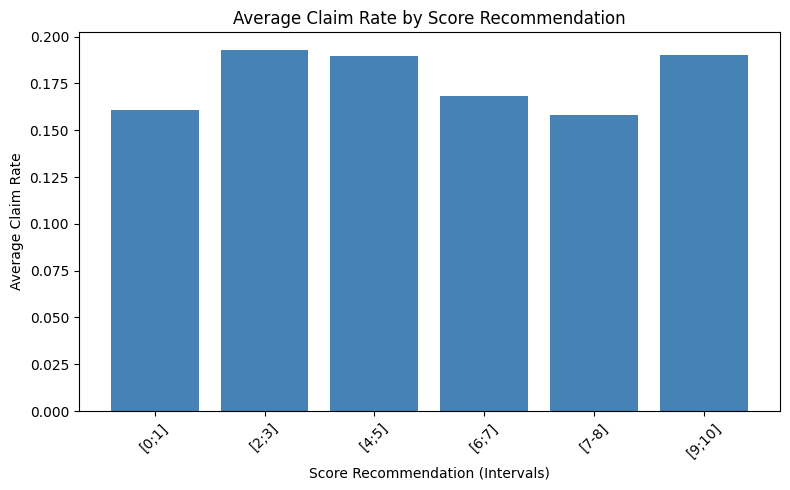

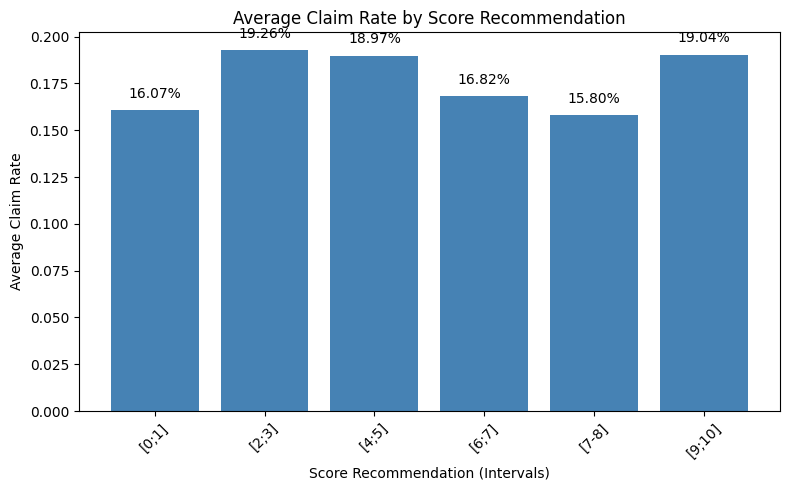

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate average claim rate (mean of Risque) for each score range
score_risk = df_merged.groupby("Score_recommandation")["Risque"].mean().reset_index()

# Sort by score range (if needed)
score_risk = score_risk.sort_values("Score_recommandation")

# Plot
plt.figure(figsize=(8,5))
plt.bar(score_risk["Score_recommandation"], score_risk["Risque"], color='steelblue')
plt.title("Average Claim Rate by Score Recommendation")
plt.xlabel("Score Recommendation (Intervals)")
plt.ylabel("Average Claim Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Add labels
plt.figure(figsize=(8,5))
bars = plt.bar(score_risk["Score_recommandation"], score_risk["Risque"], color='steelblue')
plt.title("Average Claim Rate by Score Recommendation")
plt.xlabel("Score Recommendation (Intervals)")
plt.ylabel("Average Claim Rate")
plt.xticks(rotation=45)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()






In [ ]:
# --------------------------------------------------------------
# CORRELATION ANALYSIS
# --------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric variables
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

# Compute Pearson correlations with the target variable 'Risque'
corr = df_merged[numeric_cols].corr()["Risque"].sort_values(ascending=False)

# Display the top 10 correlations
print("📊 Top numerical correlations with claim risk:")
print(corr.head(10))

# Visualize correlation matrix (optional)
plt.figure(figsize=(8,6))
sns.heatmap(df_merged[numeric_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numerical Variables)")
plt.show()

In [ ]:
# --------------------------------------------------------------
# Categorical analysis — average claim rate by category
# --------------------------------------------------------------

cat_vars = ["Categorie_vehicule", "Type_zone", "CSP", "Situation_maritale", "Apporteur"]

for var in cat_vars:
    avg_risk = df_merged.groupby(var)["Risque"].mean().sort_values(ascending=False)
    print(f"\n📈 Average claim rate by {var}:")
    print(avg_risk)

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_merged[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numerical Variables and Claim Risk)")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure columns are standardized
df_merged.columns = df_merged.columns.str.strip().str.lower()

# Check if the tranche column exists
if "tranche_detaillee_unite_urbaine" not in df_merged.columns:
    raise KeyError("Column 'tranche_detaillee_unite_urbaine' not found in dataset!")

# -----------------------------------
# 1️⃣ Compute average risk per tranche
# -----------------------------------
avg_risk_tranche = (
    df_merged.groupby("tranche_detaillee_unite_urbaine", observed=False)["risque"]
    .mean()
    .reset_index()
    .sort_values("tranche_detaillee_unite_urbaine")
)

print(avg_risk_tranche)

# -----------------------------------
# 2️⃣ Plot as bar chart
# -----------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_risk_tranche,
    x="tranche_detaillee_unite_urbaine",
    y="risque",
    palette="coolwarm"
)
plt.title("Average Risk by Urban Unit Detail Tranche (1–8)")
plt.xlabel("Urban Unit Tranche (1–8)")
plt.ylabel("Average Risk")
plt.tight_layout()
plt.show()